## ARMA model

In [14]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(11)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [15]:
from statsmodels.tsa.stattools import adfuller

ADF_test_results = adfuller(ARMA_1_1)

print(f"ADF stats: {ADF_test_results[0]}")
print(f"p-value: {ADF_test_results[1]}")

ADF stats: -6.214509786526415
p-value: 5.406640272939692e-08


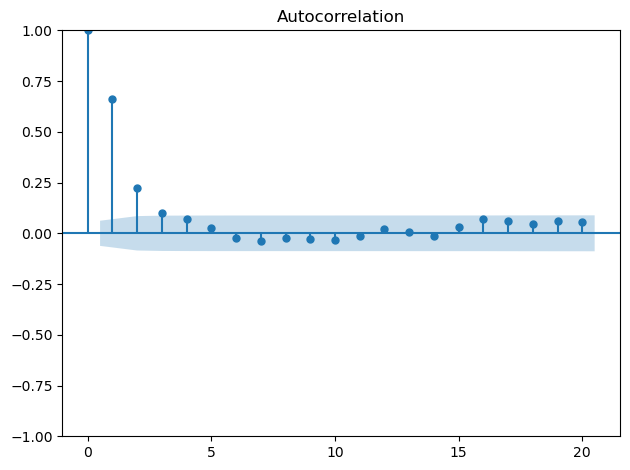

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(ARMA_1_1, lags=20)

plt.tight_layout()

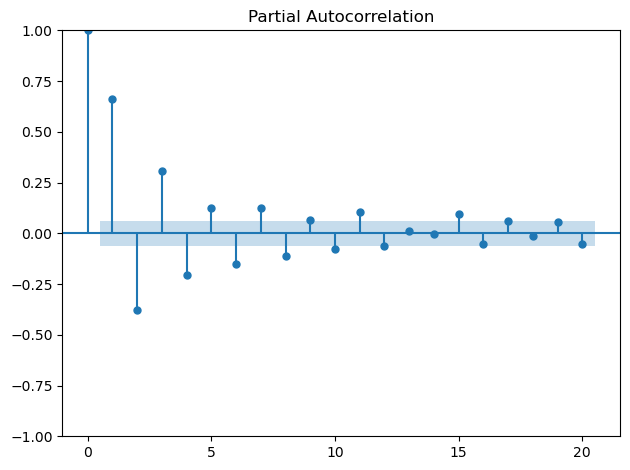

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ARMA_1_1, lags=20)

plt.tight_layout()

### Select model using AIC (Akaike information criterion)

In [18]:
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [24]:
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        
        except:
            continue
        
        aic = model.aic
        results.append([order, aic])

    results_df = pd.DataFrame(results)
    results_df.columns = ["(p, q)", "AIC"]

    results_df = results_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

    return results_df

In [25]:
result_df = optimize_ARMA(ARMA_1_1, order_list=order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p, q)",AIC
0,"(1, 1)",2859.243111
1,"(1, 2)",2861.010893
2,"(2, 1)",2861.033659
3,"(0, 3)",2862.167005
4,"(1, 3)",2862.696943
5,"(3, 1)",2862.885154
6,"(2, 2)",2863.101375
7,"(2, 3)",2864.641728
8,"(3, 2)",2865.004100
9,"(3, 3)",2865.164784


In [26]:
model = SARIMAX(ARMA_1_1, order=(1, 0, 1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

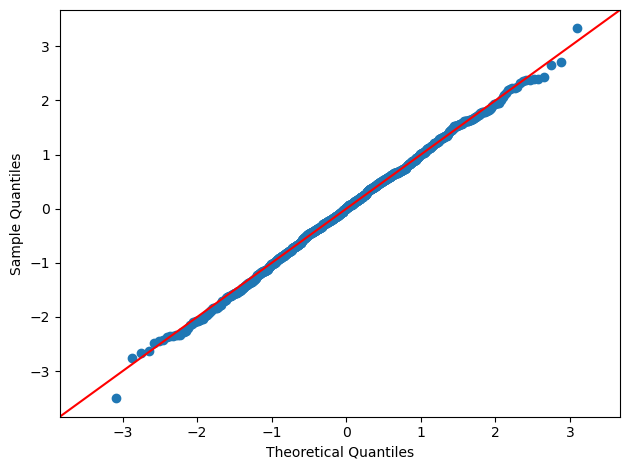

In [28]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line="45")

plt.tight_layout()

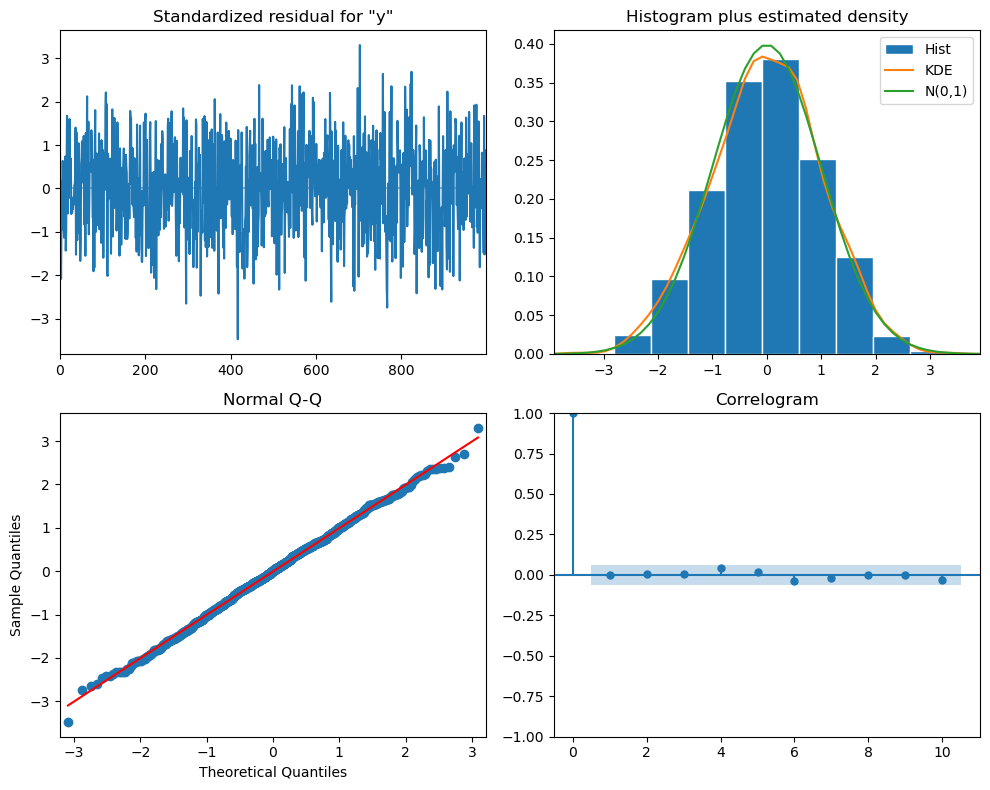

In [30]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()

In [34]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljungbox_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(ljungbox_df)

     lb_stat  lb_pvalue
1   0.006277   0.936854
2   0.030051   0.985087
3   0.042823   0.997673
4   1.698295   0.791027
5   2.094094   0.835978
6   3.437176   0.752309
7   3.742422   0.808921
8   3.742937   0.879540
9   3.746106   0.927315
10  4.719667   0.909101


### Forecasting bandwidth

In [1]:
import pandas as pd

bandwidth_df = pd.read_csv("data/bandwidth.csv")

bandwidth_df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


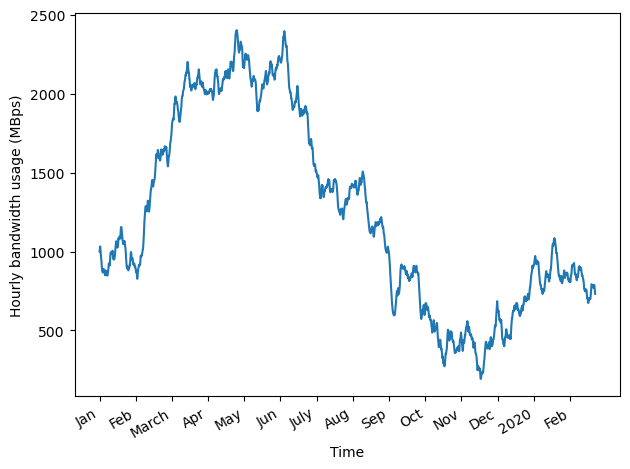

In [3]:
import matplotlib.pyplot as plt 
import numpy as np


fig, ax = plt.subplots()

ax.plot(bandwidth_df.hourly_bandwidth)
ax.set_xlabel("Time")
ax.set_ylabel("Hourly bandwidth usage (MBps)")

plt.xticks(np.arange(0, 10000, 730),
           ["Jan", "Feb", "March", "Apr", "May", "Jun", "July", "Aug", "Sep", "Oct", "Nov", "Dec", "2020", "Feb"])
fig.autofmt_xdate()
plt.tight_layout()


In [4]:
from statsmodels.tsa.stattools import adfuller

ADF_test = adfuller(bandwidth_df.hourly_bandwidth)
print(f"ADF statistics: {ADF_test[0]}")
print(f"p-value: {ADF_test[1]}")

ADF statistics: -0.8714653199452729
p-value: 0.7972240255014553


In [5]:
# Apply first order difference to make data stationary

stationary_bandwidth_df = np.diff(bandwidth_df.hourly_bandwidth, n=1)

In [6]:
new_ADF_test = adfuller(stationary_bandwidth_df)

print(f"ADF statistics: {new_ADF_test[0]}")
print(f"p-value: {new_ADF_test[1]}")

ADF statistics: -20.694853863789017
p-value: 0.0


In [7]:
diff_bandwidth_df = pd.DataFrame(
    {"bandwidth_diff": stationary_bandwidth_df}
)

train = diff_bandwidth_df[:-168]
test = diff_bandwidth_df[-168:]


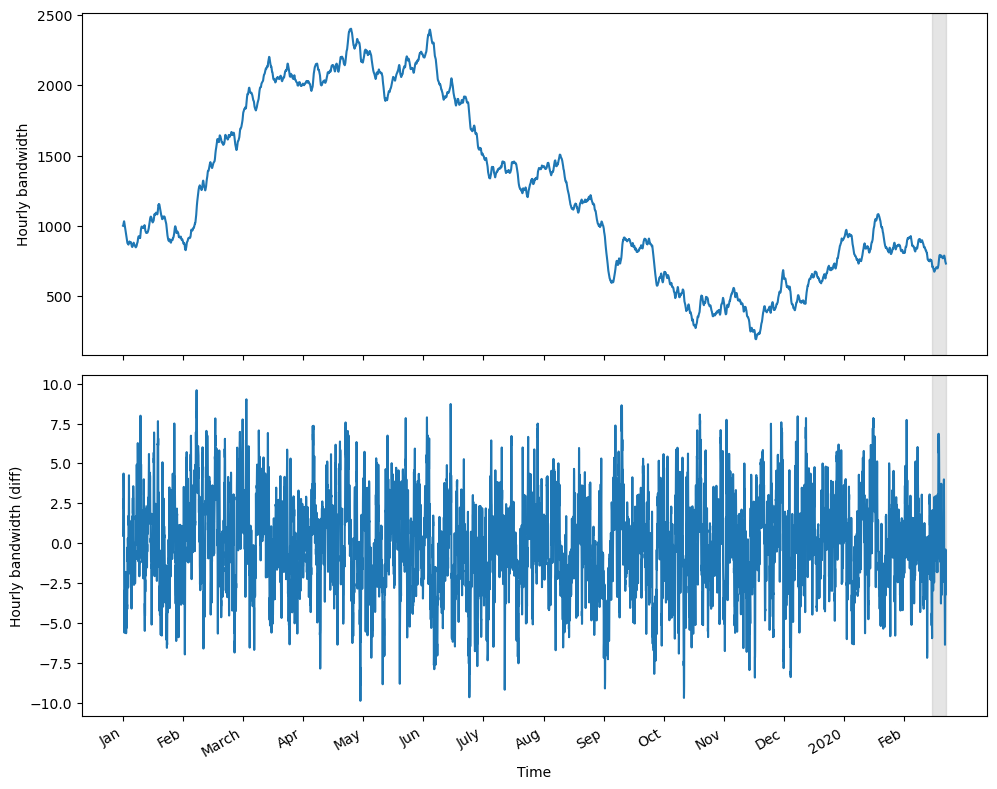

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(bandwidth_df.hourly_bandwidth)
ax1.set_xlabel("Time")
ax1.set_ylabel("Hourly bandwidth")
ax1.axvspan(9831, 10000, color="#808080", alpha=0.2)

ax2.plot(diff_bandwidth_df.bandwidth_diff)
ax2.set_xlabel("Time")
ax2.set_ylabel("Hourly bandwidth (diff)")
ax2.axvspan(9830, 9999, color="#808080", alpha=0.2)

plt.xticks(np.arange(0, 10000, 730),
           ["Jan", "Feb", "March", "Apr", "May", "Jun", "July", "Aug", "Sep", "Oct", "Nov", "Dec", "2020", "Feb"])
fig.autofmt_xdate()
plt.tight_layout()

In [12]:
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        
        except:
            continue
        
        aic = model.aic
        results.append([order, aic])

    results_df = pd.DataFrame(results)
    results_df.columns = ["(p, q)", "AIC"]

    results_df = results_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

    return results_df

In [13]:
from itertools import product


ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [14]:
res_df = optimize_ARMA(train["bandwidth_diff"], order_list)
res_df

  0%|          | 0/16 [00:00<?, ?it/s]

/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p, q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


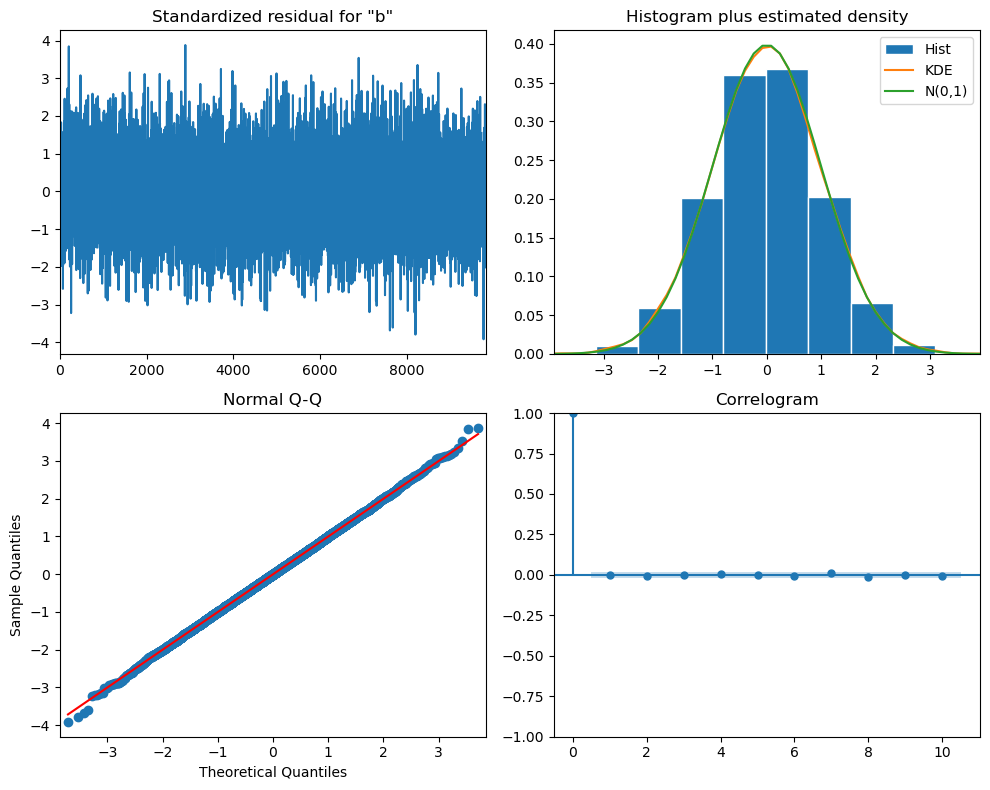

In [16]:
model = SARIMAX(train["bandwidth_diff"], order=(2, 0, 2), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid

ljungbox_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(ljungbox_df)

     lb_stat  lb_pvalue
1   0.042190   0.837257
2   0.418364   0.811247
3   0.520271   0.914416
4   0.850554   0.931545
5   0.850841   0.973678
6   1.111754   0.981019
7   2.124864   0.952607
8   3.230558   0.919067
9   3.248662   0.953615
10  3.588289   0.964015
